# CS178 Final Project
## IMDB Reviews dataset
### Students:
Rebecca Park : 50269810
Nick Hosun Song : 65482420

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , make_scorer, zero_one_loss
from scipy.sparse import csr_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
## conda install libsvm
## conda install libsvm-python
from libsvm.svmutil import svm_train, svm_predict, svm_problem, svm_parameter , svm_read_problem


In [3]:
#Load the vocab from given data will correlate to bagofwords(feat) file
def load_vocab(vocab_file):
    with open(vocab_file, 'r',encoding ='utf-8') as file:
        vocab = file.read().splitlines()
    return {index: word for index, word in enumerate(vocab)}

vocab = load_vocab('imdb.vocab')
def convert_to_csr(data, num_features):
    row_ind = []
    col_ind = []
    data_values = []

    for i, row in enumerate(data):
        for feature_index, feature_value in row.items():
            row_ind.append(i)
            col_ind.append(feature_index)
            data_values.append(feature_value)

    return csr_matrix((data_values, (row_ind, col_ind)), shape=(len(data), num_features))

num_features = len(vocab)

y_train, X_train = svm_read_problem('train/labeledBow.feat')
y_test, X_test = svm_read_problem('test/labeledBow.feat')

X_train_csr = convert_to_csr(X_train,num_features)
X_test_csr = convert_to_csr(X_test,num_features)

#convert labels into binary format
#positive = 1 (7 , 8 , 9 , 10)
#negative = 0 (1, 2 , 3 , 4)
y_train_binary = [1 if y > 6 else 0 for y in y_train]
y_test_binary = [1 if y > 6 else 0 for y in y_test]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split( X_train_csr, y_train_binary, test_size=0.2, random_state=123)


## Sentiment Analysis
We are focusing on creating a sentiment analysis which is a natural language processing task that tries to determine 
the emotional tone of a piece of text which in our case is an IMDB movie review. We will be classifying our data into 
positive (1) and negative (0) labels. Our data was provided to us in a .feat format so all we had to do for data preprocessing
was convert the format into csr in order for us to be able to use Scikit_learn packages.

## Naive Bayes
The first model is Naive Bayes which assumes that all the features are independent of each other. Although we know that there are contextual relationships between words we use this as a baseline as Naive Bayes is a simple but somewhat effective model for text classification tasks.

In [3]:
# Assuming X_train_csr, y_train_binary, X_test_csr, y_test_binary are defined

# Initialize Naive Bayes model
model = MultinomialNB()

# Train the model using the training set
model.fit(X_train_csr, y_train_binary)

# Make predictions for both the training and test sets
y_pred_train = model.predict(X_train_csr)
y_pred_test = model.predict(X_test_csr)

# Calculate the error rate and F1 score for the training set
train_error_rate = 1 - accuracy_score(y_train_binary, y_pred_train)
train_f1_score = f1_score(y_train_binary, y_pred_train)

# Calculate the error rate and F1 score for the test set
test_error_rate = 1 - accuracy_score(y_test_binary, y_pred_test)
test_f1_score = f1_score(y_test_binary, y_pred_test)

# Print the results
print(f"Training Error Rate: {train_error_rate:.4f}")
print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Training Error Rate: 0.1000
Training F1 Score: 0.8962
Test Error Rate: 0.1864
Test F1 Score: 0.8010


## Linear SVM
The second type of model we chose was an SVM with a linear kernel. The linear kernel tends to work well when data is linearly separable in a feature space.
The hyperparameter that we chose to tune was the regularization strength parameter (C). We chose to use L2 regularization as it doesn't force feature selection as aggressively as L1 regularization. Tuning the reglarization is done in order to prevent overfitting and improve the generalization of the model. The strength parameter C encourages the model to have smaller weights/coefficients for each of the features, which will make the model less sensitive to the noise in the training data. This will help us control the margin between the decision boundary and the training points. In using a Linear SVM we are aiming to find the decision boundary that maximizes the margin between the classes while also correctly classifying the training examples. 

C = 1e-05
Validation Error Rate: 0.2356
Validation F1 Score: 0.7637
Test Error Rate: 0.2308
Test F1 Score: 0.7691

C = 0.0001
Validation Error Rate: 0.1446
Validation F1 Score: 0.8566
Test Error Rate: 0.1557
Test F1 Score: 0.8461

C = 0.001
Validation Error Rate: 0.1074
Validation F1 Score: 0.8926
Test Error Rate: 0.1203
Test F1 Score: 0.8804

C = 0.01
Validation Error Rate: 0.1052
Validation F1 Score: 0.8947
Test Error Rate: 0.1234
Test F1 Score: 0.8767

C = 0.1
Validation Error Rate: 0.1198
Validation F1 Score: 0.8794
Test Error Rate: 0.1420
Test F1 Score: 0.8570

C = 1
Validation Error Rate: 0.1278
Validation F1 Score: 0.8715
Test Error Rate: 0.1530
Test F1 Score: 0.8454



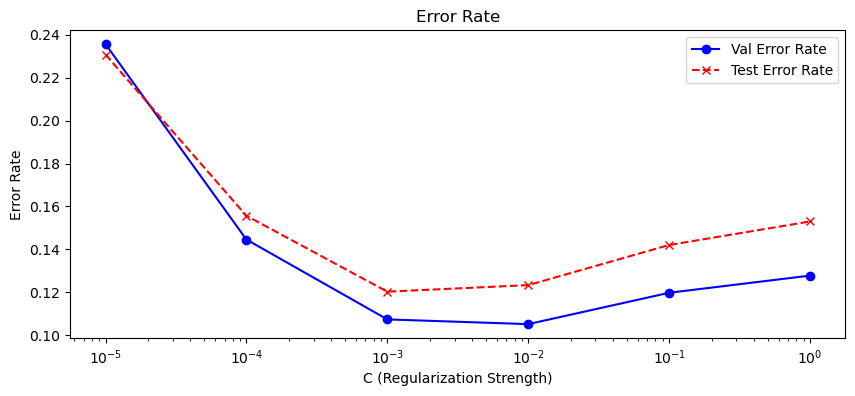

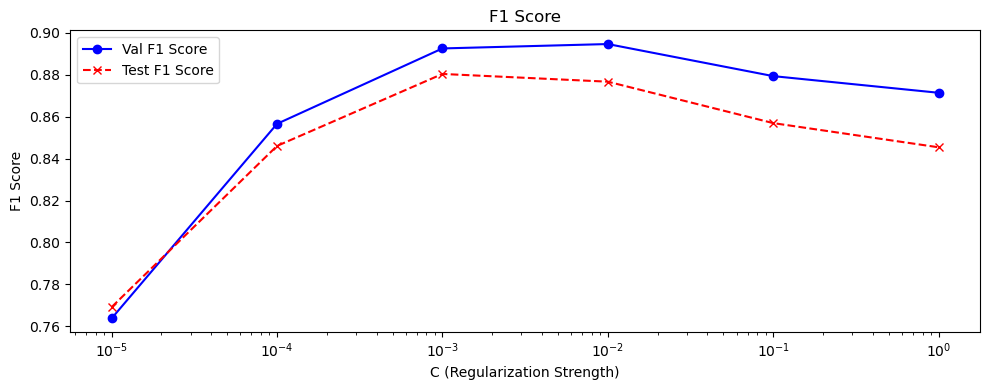

In [4]:
# Testing with linear kernel with different regularization strengths and cross-validation to test different metrics
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Dictionaries to store validation and test metrics
val_metrics_linear = {'error_rate': [], 'f1': []}
test_metrics_linear = {'error_rate': [], 'f1': []}

# Loop through and create a model for each regularization strength
for C in C_values:
    model = LinearSVC(C=C, dual=False, max_iter=5000)
    model.fit(X_train_split, y_train_split)

    # Validate the model
    y_pred_val = model.predict(X_val_split)
    val_metrics_linear['error_rate'].append(1 - accuracy_score(y_val_split, y_pred_val))
    val_metrics_linear['f1'].append(f1_score(y_val_split, y_pred_val))

    # Test the model
    y_pred_test = model.predict(X_test_csr)
    test_metrics_linear['error_rate'].append(1 - accuracy_score(y_test_binary, y_pred_test))
    test_metrics_linear['f1'].append(f1_score(y_test_binary, y_pred_test))

    # Print the results for each C value
    print(f"C = {C}")
    print(f"Validation Error Rate: {val_metrics_linear['error_rate'][-1]:.4f}")
    print(f"Validation F1 Score: {val_metrics_linear['f1'][-1]:.4f}")
    print(f"Test Error Rate: {test_metrics_linear['error_rate'][-1]:.4f}")
    print(f"Test F1 Score: {test_metrics_linear['f1'][-1]:.4f}")
    print()

def plot_metric(metric, title):
    plt.plot(C_values, val_metrics_linear[metric], marker='o', color='b', label='Val ' + title)
    plt.plot(C_values, test_metrics_linear[metric], linestyle='--', marker='x', color='r', label='Test ' + title)
    plt.xscale('log')
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()

# Plot the metrics for error rate and F1 score
plt.figure(figsize=(10, 4))
plot_metric('error_rate', 'Error Rate')

plt.figure(figsize=(10, 4))
plot_metric('f1', 'F1 Score')

plt.tight_layout()
plt.show()


## Analysis of Linear SVM tuning
In our analysis of the Linear SVM, after computing all of the linear models using the different Regularization strengths, we measure 4 different metrics.
- Error Rate : the proportion of misclassified instances
- Precision : proportion of models ability to correctly predict positive cases (minimize false positives)
- Recall : proportion of true positive predictions out of all the actual positive cases (minimize false negatives)
- F1 score: the mean between precision and recall finds the best model that captures the balance between minimizing both false positives and negatives.

From the graphs shown above, we can clearly tell that when using a Linear SVM a regularization strength of .001 gives us the best overall performance. If we were to focus only on the precision metric we cold arge that choosing to go with .01 would be better, but for our dataset we want a good balance of both false positives and negatives. So if we choose based off the error rate as well as the F1 score we can confidently say that choosing the Linear SVM model with a regularization strength of .001 is the best choice.


In [5]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# implementing feedforward neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,SGD

#convert to dense array
X_train_dense = X_train_csr.toarray()
X_test_dense = X_test_csr.toarray() 
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)

#making sure we are using nparrays in order to pass through the neural network
# print(type(X_train_dense), X_train_dense.shape)
# print(type(X_test_dense), X_test_dense.shape)
# print(type(y_train_binary))
# print(type(y_test_binary))

#optimizer learning rate:
optimizer = Adam(learning_rate=.00001)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=num_features))
model.add(Dropout(0.1))  # dropout layer to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification

#will adjust the optimizer ~ SGD,adam,rmsprop,adamax,nadam,etc.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#will adjust epochs, batch_size, and validation_split to find the optimal range
history = model.fit(X_train_dense, y_train_binary, epochs=8, batch_size=32, validation_split=0.20)

loss, accuracy = model.evaluate(X_test_dense, y_test_binary)
error_rate = 1 - accuracy

print(f"Test Loss: {loss:.4f} , Test accuracy: {accuracy:.4f} , Test Error Rate: {error_rate:.4f}")


MemoryError: Unable to allocate 16.7 GiB for an array with shape (25000, 89527) and data type float64

## Feedforward Neural Network
The third model we chose was a feedforward neural network, which allowed us to create a less complex neural network to prevent overfitting.

## Hyperparameters to adjust and test:
- optimizer - updates the weights of the neurons during training
- epochs - # of times we run through entire dataset forward and backwards
- batch_size - #of samples per update ~ takes the total amount of bags for training and divides by batchsize to show how much we are running per epoch
- validation_split : splits data into training data and test data, .2 = 20% saved for validation and does not get passed for training
  

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np

X_train_dense = X_train_csr.toarray()
X_test_dense = X_test_csr.toarray() 
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)

def create_model(num_features, hidden_layers, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=num_features))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters Grid
layer_options = [1, 2, 3]  # Example: trying 1, 2, and 3 hidden layers
neurons_options = [32, 64, 128]
dropout_options = [.1, 0.3, 0.5]
learning_rate_options = [0.001, 0.0001, 0.00001]

best_accuracy = 0
best_params = {}

for layers in layer_options:
    for neurons in neurons_options:
        for dropout_rate in dropout_options:
            for learning_rate in learning_rate_options:
                print(f"Layers: {layers}, Neurons: {neurons}, Dropout: {dropout_rate}, LR: {learning_rate}")
                model = create_model(num_features, layers, neurons, dropout_rate, learning_rate)
                
                # Early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

                # Fit the model
                model.fit(X_train_dense, y_train_binary, epochs=10, batch_size=32, validation_split=0.20, callbacks=[early_stopping])
                loss, accuracy = model.evaluate(X_test_dense, y_test_binary)

                print(f"Layers: {layers}, Neurons: {neurons}, Dropout: {dropout_rate}, LR: {learning_rate}, Test Accuracy: {accuracy:.4f}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'layers': layers, 'neurons': neurons, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print("Best Hyperparameters:", best_params)


MemoryError: Unable to allocate 16.7 GiB for an array with shape (25000, 89527) and data type float64

## Decision Trees
The fourth model we used was decision trees. Since the dataset had so many features and data points, we adjusted different hyperparameters that we thought would be the most effective in reducing overfitting, like mininum sample split, mininum sample leaf, and maximum depth. Although it did take us more time, we used entropy as our criterion as it gave slightly more accurate results compared to gini. 

Testing different min sample splits

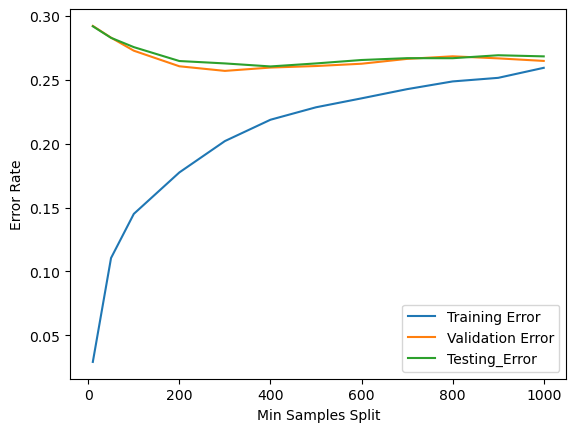

In [33]:
train_error = []
validation_error = []
testing_error = []
min_samples_split_options = [10,50,100,200,300,400,500,600,700,800,900,1000]

for min_samples_split in min_samples_split_options:
    dec_tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=123)
    dec_tree_model.fit(X_train_split,y_train_split)
    
    #training
    dec_tree_train_pred = dec_tree_model.predict(X_train_split)
    
    #validation
    dec_tree_validation_pred = dec_tree_model.predict(X_val_split)
    
    #testing
    dec_tree_test_pred = dec_tree_model.predict(X_test_csr)
    
    train_error.append(zero_one_loss(dec_tree_train_pred,y_train_split))
    validation_error.append(zero_one_loss(dec_tree_validation_pred,y_val_split))
    testing_error.append(zero_one_loss(dec_tree_test_pred,y_test_binary))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(min_samples_split_options, train_error)
ax.plot(min_samples_split_options, validation_error)
ax.plot(min_samples_split_options, testing_error)
plt.legend(['Training Error','Validation Error','Testing_Error'])
ax.set_xlabel('Min Samples Split')
ax.set_ylabel('Error Rate')
plt.show()

The testing error is lowest when min_samples_split is 400

In [40]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=400, random_state=123)
dec_tree_model.fit(X_train_split,y_train_split)

train_pred = dec_tree_model.predict(X_train_split)
validation_pred = dec_tree_model.predict(X_val_split)
test_pred = dec_tree_model.predict(X_test_csr)

print("Training Error: ",zero_one_loss(train_pred,y_train_split))
print("Validation Error: ",zero_one_loss(validation_pred,y_val_split))
print("Testing Error: ",zero_one_loss(test_pred,y_test_binary))

Training Error:  0.21875
Validation Error:  0.25960000000000005
Testing Error:  0.26048000000000004


Testing different min samples leaf

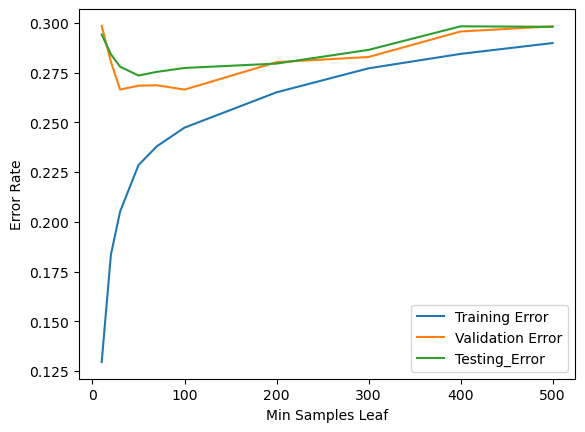

In [34]:
train_error = []
validation_error = []
testing_error = []
min_samples_leaf_options = [10,20,30,50,70,100,200,300,400,500]



for min_samples_leaf in min_samples_leaf_options:
    dec_tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=123)
    dec_tree_model.fit(X_train_split,y_train_split)
    
    #training
    dec_tree_train_pred = dec_tree_model.predict(X_train_split)
    
    #validation
    dec_tree_validation_pred = dec_tree_model.predict(X_val_split)
    
    #testing
    dec_tree_test_pred = dec_tree_model.predict(X_test_csr)
    
    train_error.append(zero_one_loss(dec_tree_train_pred,y_train_split))
    validation_error.append(zero_one_loss(dec_tree_validation_pred,y_val_split))
    testing_error.append(zero_one_loss(dec_tree_test_pred,y_test_binary))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(min_samples_leaf_options, train_error)
ax.plot(min_samples_leaf_options, validation_error)
ax.plot(min_samples_leaf_options, testing_error)
plt.legend(['Training Error','Validation Error','Testing_Error'])
ax.set_xlabel('Min Samples Leaf')
ax.set_ylabel('Error Rate')
plt.show()

The testing error is lowest when min_samples_leaf is 50

In [41]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, random_state=123)
dec_tree_model.fit(X_train_split,y_train_split)

train_pred = dec_tree_model.predict(X_train_split)
validation_pred = dec_tree_model.predict(X_val_split)
test_pred = dec_tree_model.predict(X_test_csr)

print("Training Error: ",zero_one_loss(train_pred,y_train_split))
print("Validation Error: ",zero_one_loss(validation_pred,y_val_split))
print("Testing Error: ",zero_one_loss(test_pred,y_test_binary))

Training Error:  0.22850000000000004
Validation Error:  0.26839999999999997
Testing Error:  0.27347999999999995


Testing different max depth

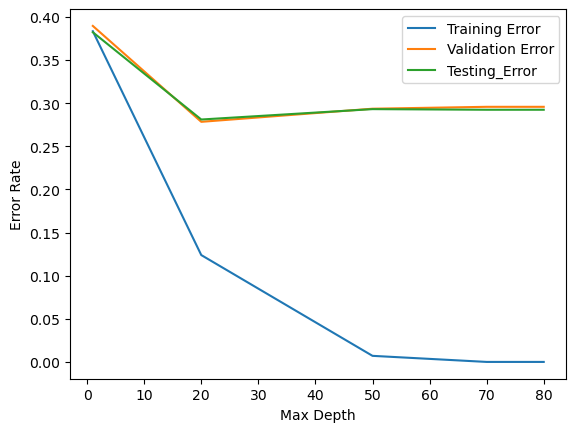

In [36]:
train_error = []
validation_error = []
testing_error = []
max_depth_options = [1,20,50,70,80]

for max_depth in max_depth_options:
    dec_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=123)
    dec_tree_model.fit(X_train_split,y_train_split)

    #training
    dec_tree_train_pred = dec_tree_model.predict(X_train_split)
    
    #validation
    dec_tree_validation_pred = dec_tree_model.predict(X_val_split)
    
    #testing
    dec_tree_test_pred = dec_tree_model.predict(X_test_csr)
    
    train_error.append(zero_one_loss(dec_tree_train_pred,y_train_split))
    validation_error.append(zero_one_loss(dec_tree_validation_pred,y_val_split))
    testing_error.append(zero_one_loss(dec_tree_test_pred,y_test_binary))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(max_depth_options, train_error)
ax.plot(max_depth_options, validation_error)
ax.plot(max_depth_options, testing_error)
plt.legend(['Training Error','Validation Error','Testing_Error'])
ax.set_xlabel('Max Depth')
ax.set_ylabel('Error Rate')
plt.show()

The testing error is lowest when max_depth is 20

In [42]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=123)
dec_tree_model.fit(X_train_split,y_train_split)

train_pred = dec_tree_model.predict(X_train_split)
validation_pred = dec_tree_model.predict(X_val_split)
test_pred = dec_tree_model.predict(X_test_csr)

print("Training Error: ",zero_one_loss(train_pred,y_train_split))
print("Validation Error: ",zero_one_loss(validation_pred,y_val_split))
print("Testing Error: ",zero_one_loss(test_pred,y_test_binary))

Training Error:  0.12390000000000001
Validation Error:  0.2784
Testing Error:  0.28108


Error rates and f1 score for decision tree classifier with no parameter adjustments

In [43]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy', random_state=123)
dec_tree_model.fit(X_train_csr, y_train_binary)
train_pred=dec_tree_model.predict(X_train_split)
val_pred=dec_tree_model.predict(X_val_split)
test_pred=dec_tree_model.predict(X_test_csr)

print(f"Training Error: {zero_one_loss(train_pred,y_train_split)}")
print(f"Validation Error: {zero_one_loss(val_pred,y_val_split)}")
print(f"Testing Error: {zero_one_loss(test_pred,y_test_binary)}")


Training Error: 0.0
Validation Error: 0.0
Testing Error: 0.28828


When comparing to the error rates for a decision tree with no parameter adjustments at all, we actually found that the parameter adjusted one wasn't much better than the one without. We suspect we might be underfitting, or that decision trees may simply not be a great classifier to use for this data set.

## Stacking
Finally after training the four different classifiers, we used stacking to combine our optimized Naive Bayes, Linear SVM, and Decision Tree models to see if a combination of all four would give us better results than individual classifiers.

In [6]:
estimators=[
    ('NB',MultinomialNB()),
    ('LS',LinearSVC(random_state=123,dual=False,max_iter=5000, C=0.001)),
    ('DT',DecisionTreeClassifier(random_state=123, min_samples_leaf=50, criterion='entropy')),
]

stackingClassifier = StackingClassifier(estimators=estimators)
stackingClassifier.fit(X_train_split, y_train_split)

train_pred=stackingClassifier.predict(X_train_split)
validation_pred=stackingClassifier.predict(X_val_split)
test_pred=stackingClassifier.predict(X_test_csr)

print(f"Training Error: {zero_one_loss(train_pred,y_train_split)}")
print(f"Training f1 score: {f1_score(y_train_split, train_pred)}")
print()
print(f"Validation Error: {zero_one_loss(validation_pred,y_val_split)}")
print(f"Validation f1 score: {f1_score(y_val_split, validation_pred)}")
print()
print(f"Testing Error: {zero_one_loss(test_pred,y_test_binary)}")
print(f"Testing f1 score: {f1_score(y_test_binary,test_pred)}")


Training Error: 0.06784999999999997
Training f1 score: 0.9319833592301139

Validation Error: 0.10840000000000005
Validation f1 score: 0.8905050505050506

Testing Error: 0.12387999999999999
Testing f1 score: 0.8749545766544191
